## Trajactory Predication

### Load + Prepare Data

In [46]:
import json
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# Load the JSON file
with open("extracted_frames/player_spatial_features.json", "r") as f:
    data = json.load(f)

# Extract x and y coordinates
coords = np.array([[entry['x_pixel'], entry['y_pixel']] for entry in data], dtype=np.float32)

# Normalize data
mean = coords.mean(axis=0)
std = coords.std(axis=0)
coords_norm = (coords - mean) / std

# Split into two halves
mid = len(coords_norm) // 2
input_seq = coords_norm[:mid]     # Use as input
target_seq = coords_norm[mid:]    # Use as ground truth


### Transformer Model Definition

In [47]:
import torch
import torch.nn as nn

class TrajectoryTransformer(nn.Module):
    def __init__(self, input_dim=2, model_dim=64, lstm_hidden_dim=64,
                 num_heads=2, num_layers=2, dropout=0.1, max_len=100):
        super().__init__()

        # Projection to model dimension
        self.input_proj = nn.Linear(input_dim, model_dim)

        # Positional Encoding (learned)
        self.pos_encoder = nn.Parameter(torch.randn(1, max_len, model_dim))

        # LSTM Layer
        self.lstm = nn.LSTM(input_size=model_dim, hidden_size=lstm_hidden_dim,
                            num_layers=1, batch_first=True, bidirectional=False)
        
        self.lstm_to_transformer = nn.Linear(lstm_hidden_dim, model_dim)
        self.ln1 = nn.LayerNorm(model_dim)

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, dropout=dropout, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Output projection back to coordinate space
        self.output_proj = nn.Linear(model_dim, input_dim)

    def forward(self, x):
        # x: (batch_size, seq_len, input_dim)
        batch_size, seq_len, _ = x.shape

        # Input projection + position encoding
        x = self.input_proj(x) + self.pos_encoder[:, :seq_len, :]  # shape: (B, T, D)

        # LSTM encoding
        lstm_out, _ = self.lstm(x)  # shape: (B, T, H)
        x = self.lstm_to_transformer(lstm_out)  # project to model_dim
        x = self.ln1(x)

        # Transformer encoding
        x = self.transformer(x)  # shape: (B, T, D)

        # Final projection to 2D coords
        return self.output_proj(x)  # shape: (B, T, 2)


### Visualize the internals of the Customized Transformer Model

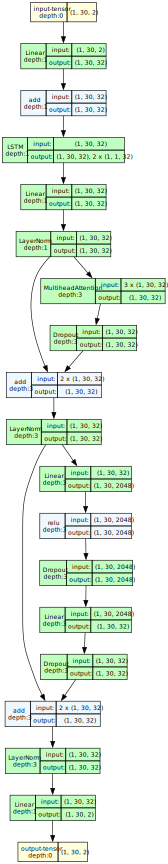

In [48]:
import torch
import torch.nn as nn
from torchview import draw_graph
from IPython.display import display  # This enables inline visualization

# Define the model
class TrajectoryTransformer(nn.Module):
    def __init__(self, input_dim=2, model_dim=32, lstm_hidden_dim=32,
                 num_heads=2, num_layers=1, dropout=0.1, max_len=50):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, model_dim)
        self.pos_encoder = nn.Parameter(torch.randn(1, max_len, model_dim))
        self.lstm = nn.LSTM(input_size=model_dim, hidden_size=lstm_hidden_dim,
                            num_layers=1, batch_first=True)
        self.lstm_to_transformer = nn.Linear(lstm_hidden_dim, model_dim)
        self.ln1 = nn.LayerNorm(model_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=model_dim, nhead=num_heads, dropout=dropout, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output_proj = nn.Linear(model_dim, input_dim)

    def forward(self, x):
        seq_len = x.size(1)
        x = self.input_proj(x) + self.pos_encoder[:, :seq_len, :]
        lstm_out, _ = self.lstm(x)
        x = self.lstm_to_transformer(lstm_out)
        x = self.ln1(x)
        x = self.transformer(x)
        return self.output_proj(x)

# Instantiate model and dummy input
model = TrajectoryTransformer()
dummy_input = torch.zeros(1, 30, 2)

# Draw the graph
graph = draw_graph(
    model,
    input_data=dummy_input,
    graph_name="TrajectoryTransformer",
    roll=True,
    save_graph=False
)

# Display the graph inline (no saving)
display(graph.visual_graph)


In [49]:
# Convert to torch tensors
input_tensor = torch.tensor(input_seq).unsqueeze(0)  # shape: (1, seq_len, 2)
target_tensor = torch.tensor(target_seq).unsqueeze(0)

model = TrajectoryTransformer()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# Train the model to predict next half
epochs = 1000
model.train()
for epoch in range(epochs):
    optimizer.zero_grad()
    output = model(input_tensor)
    loss = loss_fn(output[:, :target_tensor.size(1)], target_tensor)
    loss.backward()
    optimizer.step()
    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# Predict the second half
model.eval()
with torch.no_grad():
    predicted = model(input_tensor)[:, :target_tensor.size(1)].squeeze(0).numpy()
    predicted = predicted * std + mean  # de-normalize


Epoch 0, Loss: 0.9273
Epoch 50, Loss: 0.0070
Epoch 100, Loss: 0.0038
Epoch 150, Loss: 0.0061
Epoch 200, Loss: 0.0032
Epoch 250, Loss: 0.0028
Epoch 300, Loss: 0.0014
Epoch 350, Loss: 0.0011
Epoch 400, Loss: 0.0020
Epoch 450, Loss: 0.0015
Epoch 500, Loss: 0.0013
Epoch 550, Loss: 0.0012
Epoch 600, Loss: 0.0016
Epoch 650, Loss: 0.0008
Epoch 700, Loss: 0.0011
Epoch 750, Loss: 0.0012
Epoch 800, Loss: 0.0008
Epoch 850, Loss: 0.0008
Epoch 900, Loss: 0.0007
Epoch 950, Loss: 0.0007


### Visualize Prediction vs. Ground Truth

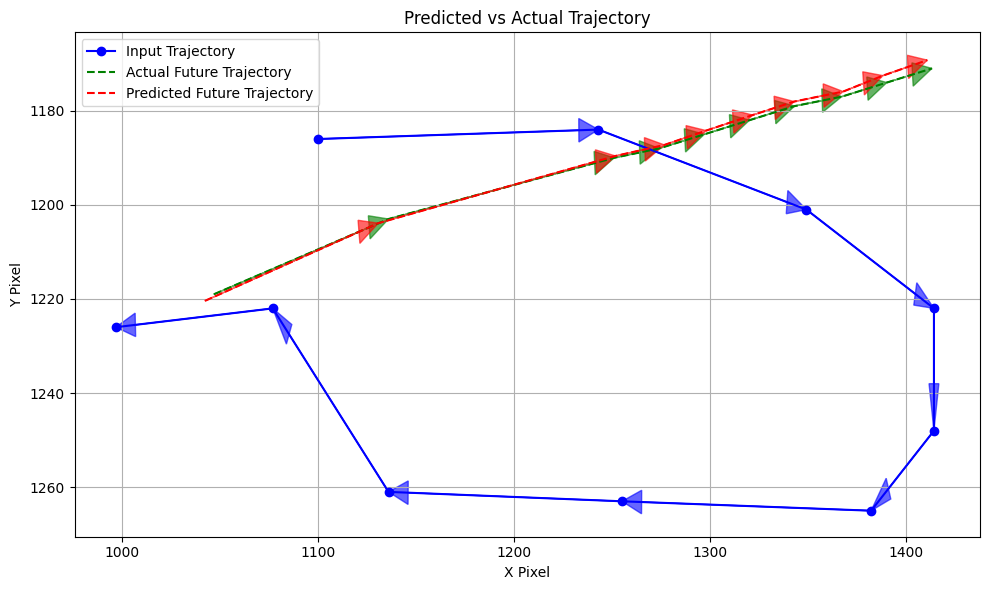

In [50]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming `coords` and `predicted` are defined
predicted = np.array(predicted)
actual = coords[mid:]

plt.figure(figsize=(10, 6))

# Plot input trajectory with arrows
for i in range(mid - 1):
    x, y = coords[i]
    dx, dy = coords[i + 1] - coords[i]
    plt.arrow(x, y, dx, dy, color='blue', length_includes_head=True,
              head_width=5, head_length=10, alpha=0.6)
plt.plot(coords[:mid, 0], coords[:mid, 1], 'bo-', label='Input Trajectory')

# Plot actual future trajectory with arrows
for i in range(len(actual) - 1):
    x, y = actual[i]
    dx, dy = actual[i + 1] - actual[i]
    plt.arrow(x, y, dx, dy, color='green', length_includes_head=True,
              head_width=5, head_length=10, alpha=0.6)
plt.plot(actual[:, 0], actual[:, 1], 'g--', label='Actual Future Trajectory')

# Plot predicted trajectory with arrows
for i in range(len(predicted) - 1):
    x, y = predicted[i]
    dx, dy = predicted[i + 1] - predicted[i]
    plt.arrow(x, y, dx, dy, color='red', length_includes_head=True,
              head_width=5, head_length=10, alpha=0.6)
plt.plot(predicted[:, 0], predicted[:, 1], 'r--', label='Predicted Future Trajectory')

plt.xlabel("X Pixel")
plt.ylabel("Y Pixel")
plt.title("Predicted vs Actual Trajectory")
plt.legend()
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()


### Evaluation

In [51]:
import numpy as np

def compute_ade_fde(predicted, actual):
    """
    Compute Average Displacement Error (ADE) and Final Displacement Error (FDE)
    for single trajectories (numpy arrays).

    predicted: np.array (T, 2)
    actual: np.array (T, 2)

    Returns:
        ade: float
        fde: float
    """
    assert predicted.shape == actual.shape, "Shape mismatch between predicted and actual"

    dist = np.linalg.norm(predicted - actual, axis=1)  # Euclidean distance per timestep
    ade = np.mean(dist)
    fde = dist[-1]

    return ade, fde

# Example usage with your data:
# predicted and actual are numpy arrays of shape (T, 2)
ade, fde = compute_ade_fde(predicted, actual)

print(f"Average Displacement Error (ADE): {ade:.4f}")
print(f"Final Displacement Error (FDE): {fde:.4f}")


Average Displacement Error (ADE): 2.4428
Final Displacement Error (FDE): 2.9598
